<a href="https://colab.research.google.com/github/DABallentine/knowledge_discovery_charlotte/blob/Dustin/Jupiter%20Notebooks/Data_Preparation_for_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Charlotte 311 Service Request Analysis

## <b> Data Preparation for Modeling </b>

Our plan for modeling consists of four primary methods: 
- Clustering
- Association Rule Mining
- Linear Regression
- Logistic Regression. 

Before we can begin most of these techniques, we will need to transform our existing data into a form suitable for the algorithm to be applied.

Currently, our data exists in this form:

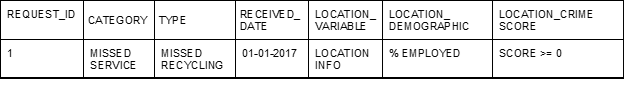

Each record in the data represents a single 311 request. However, as stated in our research question, we are interested in whether “different areas within the city of Charlotte experience higher recurrence of any type of 311 service request than other areas” and then exploring any correlations between an area’s 311 service request profile and any “red-line districts or other known demographic or socioeconomic profiles”. Thus, the entity (i.e. record) of primary interest to us is the area, not the single request, and we will need to generally transform the data into the form below:

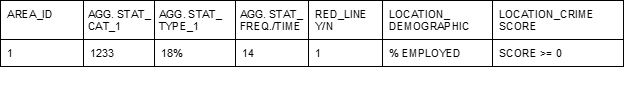

Since the crime score exists by month for each area, we will end up with one record for each area for each month.


In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
plt.style.use('ggplot')

# Function to read data from URL
def read_data_from_URL(url):
    df=pd.read_csv(url)
    return df

In [2]:
# Read in the merged, preprocessed data
serv_req_url='https://bitbucket.org/nthammad-uncc/knowledge_discovery_charlotte/raw/main/data/merged_requests.zip'
requests = read_data_from_URL(serv_req_url)
requests.head()

,Unnamed: 0,OBJECTID,DEPARTMENT,REQUEST_NO,REQUEST_CAT,REQUEST_TYPE,RECEIVED_DATE,RECEIVED_MONTH,RECEIVED_YEAR,SEASON,INTERNAL_FIELD_OBSERVATION,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,ZIP_CODE,X_COORD,Y_COORD,LATITUDE,LONGITUDE,RECEIVED_DAY,TOTAL_CALLS,ADDRESS_ID,CRIME_SCORE,EMPLOYED_All,PERCENT EMPLOYED_In labor force,PERCENT EMPLOYED_Not in labor force,PERCENT EMPLOYED_Female Only,COMMUTING TO WORK_All,PERCENT COMMUTING TO WORK_By Car,PERCENT COMMUTING TO WORK_Public transportation,PERCENT COMMUTING TO WORK_Walk,PERCENT COMMUTING TO WORK_Other,PERCENT COMMUTING TO WORK_Worked at home,INCOME AND BENEFITS_Total households,PERCENT HOUSEHOLD INCOME_Lower Income Households,PERCENT HOUSEHOLD INCOME_Mid Income Households,PERCENT HOUSEHOLD INCOME_Higher Income Households,PERCENT HOUSEHOLD INCOME_Retired Householders,INCOME AND BENEFITS_Median households income (dollars),INCOME AND BENEFITS_Mean households income (dollars),INCOME AND BENEFITS_Per capita Income,INCOME AND BENEFITS_Median earnings for workers (dollars),PERCENT INSURED_Population with health insurance,PERCENT INSURED_Population without health insurance,PERCENTAGE BELOW POVERTY LEVEL_All,HISTORIC_REDLINING
0,0,1,Solid Waste Services,6402056,NON_RECYCLABLE ITEMS,NON_RECYCLABLE ITEMS,2016-11-07 14:00:00,11,2016,4,N,215.0,3601.0,28226,1458251.0,508075.0,35.132444,-80.812089,2016-11-07,15,21882,0.000311,3571.000000,0.705954,0.294046,0.547692,2315.000000,0.867800,0.020731,0.014661,0.012267,0.084541,1852.928571,0.213424,0.576240,0.210336,0.157483,79300.428571,111885.642857,47529.928571,43332.642857,0.917971,0.082029,7.135714,NaN
1,1,2,Housing and NBHD Serv,6402064,UTILITY VERIFICATION LTR,UTILITY VERIFICATION LTR,2016-11-07 14:00:00,11,2016,4,N,265.0,4124.0,28269,1468687.0,587226.0,35.350408,-80.781941,2016-11-07,10,43252,0.000311,3877.600000,0.740375,0.259625,0.528438,2580.900000,0.895156,0.020414,0.007693,0.010918,0.065818,1925.100000,0.241599,0.674026,0.084375,0.129942,63391.250000,74852.450000,29914.900000,37226.300000,0.869184,0.130816,8.050000,NaN
2,2,3,Solid Waste Services,6402082,NON_RECYCLABLE ITEMS,NON_RECYCLABLE ITEMS,2016-11-07 14:00:00,11,2016,4,N,103.0,523.0,28213,1471481.0,562513.0,35.282654,-80.771094,2016-11-07,7,73999,0.002486,3095.470588,0.700170,0.299830,0.531391,1856.411765,0.885311,0.040584,0.029221,0.010399,0.034484,1308.647059,0.462024,0.500445,0.037530,0.113167,41973.411765,51723.764706,19338.294118,23576.882353,0.814082,0.185918,25.811765,NaN
3,3,4,Solid Waste Services,6402103,MISSED SERVICE,MISSED RECYCLING,2016-11-07 14:00:00,11,2016,4,N,158.0,1801.0,28216,1438992.0,568604.0,35.297745,-80.880327,2016-11-07,21,8430,0.002020,3548.600000,0.680489,0.319511,0.539649,2128.266667,0.865405,0.057418,0.021834,0.017391,0.037952,1645.333333,0.393800,0.552855,0.053345,0.128969,46401.066667,59119.666667,22976.800000,28399.600000,0.834642,0.165358,16.960000,NaN
4,4,6,Finance/City,6402112,CWP,CWP REQUEST,2016-11-07 14:00:00,11,2016,4,N,88.0,309.0,28208,1439454.0,552715.0,35.254120,-80.877772,2016-11-07,7,75771,0.003730,2972.444444,0.720768,0.279232,0.527302,1835.777778,0.812170,0.081005,0.039119,0.039021,0.028684,1481.222222,0.451759,0.497509,0.050732,0.097692,42745.529412,53659.352941,23808.882353,29559.117647,0.825033,0.174967,20.682353,Y


## Initial Feature Selection

### Rejection
The majority of the income and economic variables serve as alternative target variables, but in general do not provide predictive value for the task at hand.

Initial variable rejections:
- Unnamed: 0
- OBJECTID
- DEPARTMENT
- REQUEST_NO
- X_COORD, Y_COORD, LATITUDE, LONGITUDE
- Income and economic variables except for INCOME AND BENEFITS_Median households income and HISTORIC REDLINING, which are our two target candidates.

### Selection

For each neighborhood profile area, we will compute the following summary statistics for each category, meaning each of the 4 statistics below represents 39 features, 1 per category.
- [Category Name]_VOL:	Volume of a category's 311 requests for that month, adjusted for the population of the area
- [Category Name]_VAR: Variance in daily volume for the month
- [Category Name]_DIST: Distribution of this request category across the area, i.e. was it mostly a few addresses submitting lots of them or many addresses submitting 1 each? (This may be indirectly assessing proportion of apartment complexes to single-family homes, which might not be useful)
- [Category Name]_LATE: Proportion of requests submitted after 9 pm

In addition to the above calculated 311 request features, each record will contain the following additional features:
- CRIME SCORE: Available monthly for each area
- CRIME_REQUEST_INTERACTION: Possible interaction between crime and total 311 volume
- HISTORIC_REDLINING: Red, yellow, green, or blue as determined by the city in 1935 (Target)
- INCOME AND BENEFITS_Median households income (Target)

### Result
The resulting dataset will contain 158 predictor features and two target variables.

In [3]:
# Drop unneeded columns as listed above
# Drop unneeded columns as listed above
records = requests.drop(columns=['Unnamed: 0', 'OBJECTID', 'DEPARTMENT', 'REQUEST_NO',
                                'BLOCK_NO', 'ZIP_CODE', 'X_COORD',
                                'Y_COORD', 'LATITUDE', 'LONGITUDE',
                                'PERCENT EMPLOYED_In labor force',
                                'PERCENT EMPLOYED_Not in labor force',
                                'PERCENT EMPLOYED_Female Only', 'COMMUTING TO WORK_All',
                                'PERCENT COMMUTING TO WORK_By Car',
                                'PERCENT COMMUTING TO WORK_Public transportation',
                                'PERCENT COMMUTING TO WORK_Walk',
                                'PERCENT COMMUTING TO WORK_Other',
                                'PERCENT COMMUTING TO WORK_Worked at home',
                                'INCOME AND BENEFITS_Total households',
                                'PERCENT HOUSEHOLD INCOME_Lower Income Households',
                                'PERCENT HOUSEHOLD INCOME_Mid Income Households',
                                'PERCENT HOUSEHOLD INCOME_Higher Income Households',
                                'PERCENT HOUSEHOLD INCOME_Retired Householders',
                                'INCOME AND BENEFITS_Mean households income (dollars)',
                                'INCOME AND BENEFITS_Per capita Income',
                                'INCOME AND BENEFITS_Median earnings for workers (dollars)',
                                'PERCENT INSURED_Population with health insurance',
                                'PERCENT INSURED_Population without health insurance',
                                'PERCENTAGE BELOW POVERTY LEVEL_All'])

In [4]:
# Create a new index column to combine month, year, and neighborhood profile area:
records['MERGE_INDEX'] = requests['RECEIVED_MONTH'].astype('str')+'_'+requests['RECEIVED_YEAR'].astype('str')+'_'+requests['NEIGHBORHOOD_PROFILE_AREA'].astype('str')
records['REQ_COUNT']=1

In [5]:
records.head()

,REQUEST_CAT,REQUEST_TYPE,RECEIVED_DATE,RECEIVED_MONTH,RECEIVED_YEAR,SEASON,INTERNAL_FIELD_OBSERVATION,NEIGHBORHOOD_PROFILE_AREA,RECEIVED_DAY,TOTAL_CALLS,ADDRESS_ID,CRIME_SCORE,EMPLOYED_All,INCOME AND BENEFITS_Median households income (dollars),HISTORIC_REDLINING,MONTH-YEAR,MERGE_INDEX,REQ_COUNT
0,NON_RECYCLABLE ITEMS,NON_RECYCLABLE ITEMS,2016-11-07 14:00:00,11,2016,4,N,215.0,2016-11-07,15,21882,0.000311,3571.000000,79300.428571,NaN,2016-11,11_2016_215.0,1
1,UTILITY VERIFICATION LTR,UTILITY VERIFICATION LTR,2016-11-07 14:00:00,11,2016,4,N,265.0,2016-11-07,10,43252,0.000311,3877.600000,63391.250000,NaN,2016-11,11_2016_265.0,1
2,NON_RECYCLABLE ITEMS,NON_RECYCLABLE ITEMS,2016-11-07 14:00:00,11,2016,4,N,103.0,2016-11-07,7,73999,0.002486,3095.470588,41973.411765,NaN,2016-11,11_2016_103.0,1
3,MISSED SERVICE,MISSED RECYCLING,2016-11-07 14:00:00,11,2016,4,N,158.0,2016-11-07,21,8430,0.002020,3548.600000,46401.066667,NaN,2016-11,11_2016_158.0,1
4,CWP,CWP REQUEST,2016-11-07 14:00:00,11,2016,4,N,88.0,2016-11-07,7,75771,0.003730,2972.444444,42745.529412,Y,2016-11,11_2016_88.0,1


In [51]:
# Group, sum, and transpose request count by category per month for each neighborhood profile area (named for consistency with the association rules "basket" metaphor)
request_basket = (records
          .groupby(['MERGE_INDEX','REQUEST_CAT'])['REQ_COUNT']
          .sum().unstack().reset_index().fillna(0)
          .set_index('MERGE_INDEX'))
request_basket.head()

REQUEST_CAT,311 DOCUMENT,ADMINISTRATIVE ACTIONS,ADOPT-A PICKUP SWS,ANIMAL FOUND REPORT,BLOCKAGE,BOARDED UP STRUCTURE,BULKY ITEM,CART,CLEANLINESS,COMPLAINT,CONTENT IMPROVEMENT PROG,CUSTOMER FEEDBACK,CWP,DEAD ANIMAL COLLECTION,DISABILITY ACT,DISABLED SERVICE,ESCALATION REQUEST,FIELD OBSERVED PROBLEM,GARBAGE,HNS HEALTH AND SANITATION,HNS HOUSING,MISSED SERVICE,NON_RECYCLABLE ITEMS,PARK & REC SVC REQUEST,RECYCLABLE ITEMS,RECYCLING,REQUEST FOR SPEAKER,STW CNTY WATER QUALITY,STW OTHER,SW ONLY-DOOR HANGER LEFT,TIRES,TRANSPORTATION,UTILITY VERIFICATION LTR,VIOLATIONS,WEATHER AND ENVIRONMENTAL,YARD WASTE,ZON GENERAL INFO INQUIRY,ZONING,ZONING/COMPLAINT/ INSPECT
MERGE_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10_2016_10.0,3.0,2.0,0.0,0.0,0.0,0.0,2.0,18.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,12.0,5.0,1.0,85.0,0.0,18.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0
10_2016_100.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,0.0,0.0,42.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
10_2016_101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10_2016_102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,1.0,0.0,20.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
10_2016_103.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,19.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


In [53]:
## CATEGORY_VOL

# Aggregate total population for each area by month
employment_nums = (records
          .groupby(['MERGE_INDEX'])['EMPLOYED_All']
          .agg('mean').reset_index().fillna(0)
          .set_index('MERGE_INDEX'))

# Divide the initial 39 columns by the population of that region / 1000 to number of requests per 1000 people
vols = request_basket.div((employment_nums.values)/1000).add_suffix('_VOL') # appending "_VOL" to the name of each of these columns, this is now our first of the 4 key variables.
vols.head()

REQUEST_CAT,311 DOCUMENT_VOL,ADMINISTRATIVE ACTIONS_VOL,ADOPT-A PICKUP SWS_VOL,ANIMAL FOUND REPORT_VOL,BLOCKAGE_VOL,BOARDED UP STRUCTURE_VOL,BULKY ITEM_VOL,CART_VOL,CLEANLINESS_VOL,COMPLAINT_VOL,CONTENT IMPROVEMENT PROG_VOL,CUSTOMER FEEDBACK_VOL,CWP_VOL,DEAD ANIMAL COLLECTION_VOL,DISABILITY ACT_VOL,DISABLED SERVICE_VOL,ESCALATION REQUEST_VOL,FIELD OBSERVED PROBLEM_VOL,GARBAGE_VOL,HNS HEALTH AND SANITATION_VOL,HNS HOUSING_VOL,MISSED SERVICE_VOL,NON_RECYCLABLE ITEMS_VOL,PARK & REC SVC REQUEST_VOL,RECYCLABLE ITEMS_VOL,RECYCLING_VOL,REQUEST FOR SPEAKER_VOL,STW CNTY WATER QUALITY_VOL,STW OTHER_VOL,SW ONLY-DOOR HANGER LEFT_VOL,TIRES_VOL,TRANSPORTATION_VOL,UTILITY VERIFICATION LTR_VOL,VIOLATIONS_VOL,WEATHER AND ENVIRONMENTAL_VOL,YARD WASTE_VOL,ZON GENERAL INFO INQUIRY_VOL,ZONING_VOL,ZONING/COMPLAINT/ INSPECT_VOL
MERGE_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10_2016_10.0,1.127806,0.751871,0.0,0.0,0.0,0.0,0.751871,6.766838,0.000000,0.000000,0.0,0.0,0.0,1.503742,0.0,0.0,0.0,0.0,1.127806,4.511225,1.879677,0.375935,31.954512,0.0,6.766838,0.375935,0.0,0.0,0.0,0.0,0.375935,0.751871,0.0,0.375935,0.375935,0.375935,0.375935,1.503742,0.375935
10_2016_100.0,0.637888,0.000000,0.0,0.0,0.0,0.0,0.000000,1.275775,0.000000,0.318944,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.318944,3.827326,0.000000,0.000000,13.395640,0.0,4.784157,0.000000,0.0,0.0,0.0,0.0,0.000000,0.318944,0.0,0.000000,0.000000,0.637888,0.000000,0.318944,0.000000
10_2016_101.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.323053,0.323053,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.323053,0.323053,0.000000,1.615263,0.0,1.615263,0.000000,0.0,0.0,0.0,0.0,0.000000,0.323053,0.0,0.000000,0.000000,0.323053,0.000000,0.000000,0.000000
10_2016_102.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.633837,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.316918,3.486103,0.316918,0.000000,6.338370,0.0,1.901511,0.000000,0.0,0.0,0.0,0.0,0.000000,0.633837,0.0,0.000000,0.000000,0.633837,0.316918,0.000000,0.000000
10_2016_103.0,0.323053,0.000000,0.0,0.0,0.0,0.0,0.000000,0.646105,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.938316,0.000000,0.000000,6.138000,0.0,1.938316,0.323053,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.969158,0.000000,0.000000,0.000000


In [59]:
## CATEGORY_VAR

# Create a daily index column to facilitate easy grouping
records['DAY_MERGE_INDEX'] = requests['RECEIVED_DAY'].astype('str')+'_'+requests['NEIGHBORHOOD_PROFILE_AREA'].astype('str')

# Aggregate the daily total of each request category
variances = (records
          .groupby(['MERGE_INDEX', 'DAY_MERGE_INDEX', 'REQUEST_CAT'])['REQ_COUNT']
          .sum().unstack().reset_index().fillna(0)
          .set_index('DAY_MERGE_INDEX')
          .groupby('MERGE_INDEX').agg('var'))

# Append "_VAR" to the name of each of these columns; this is now our second of the 4 key variables.
variances = variances.add_suffix('_VAR') 
variances.head()

REQUEST_CAT,311 DOCUMENT_VAR,ADMINISTRATIVE ACTIONS_VAR,ADOPT-A PICKUP SWS_VAR,ANIMAL FOUND REPORT_VAR,BLOCKAGE_VAR,BOARDED UP STRUCTURE_VAR,BULKY ITEM_VAR,CART_VAR,CLEANLINESS_VAR,COMPLAINT_VAR,CONTENT IMPROVEMENT PROG_VAR,CUSTOMER FEEDBACK_VAR,CWP_VAR,DEAD ANIMAL COLLECTION_VAR,DISABILITY ACT_VAR,DISABLED SERVICE_VAR,ESCALATION REQUEST_VAR,FIELD OBSERVED PROBLEM_VAR,GARBAGE_VAR,HNS HEALTH AND SANITATION_VAR,HNS HOUSING_VAR,MISSED SERVICE_VAR,NON_RECYCLABLE ITEMS_VAR,PARK & REC SVC REQUEST_VAR,RECYCLABLE ITEMS_VAR,RECYCLING_VAR,REQUEST FOR SPEAKER_VAR,STW CNTY WATER QUALITY_VAR,STW OTHER_VAR,SW ONLY-DOOR HANGER LEFT_VAR,TIRES_VAR,TRANSPORTATION_VAR,UTILITY VERIFICATION LTR_VAR,VIOLATIONS_VAR,WEATHER AND ENVIRONMENTAL_VAR,YARD WASTE_VAR,ZON GENERAL INFO INQUIRY_VAR,ZONING_VAR,ZONING/COMPLAINT/ INSPECT_VAR
MERGE_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10_2016_10.0,0.201087,0.07971,0.0,0.0,0.0,0.0,0.07971,1.413043,0.000000,0.000000,0.0,0.0,0.0,0.144928,0.0,0.0,0.0,0.0,0.201087,0.695652,0.172101,0.041667,5.389493,0.0,0.543478,0.041667,0.0,0.0,0.0,0.0,0.041667,0.079710,0.0,0.041667,0.041667,0.041667,0.041667,0.144928,0.041667
10_2016_100.0,0.090476,0.00000,0.0,0.0,0.0,0.0,0.00000,0.161905,0.000000,0.047619,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.047619,1.057143,0.000000,0.000000,3.000000,0.0,0.614286,0.000000,0.0,0.0,0.0,0.0,0.000000,0.047619,0.0,0.000000,0.000000,0.090476,0.000000,0.047619,0.000000
10_2016_101.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.090909,0.090909,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.090909,0.090909,0.000000,0.272727,0.0,0.272727,0.000000,0.0,0.0,0.0,0.0,0.000000,0.090909,0.0,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000
10_2016_102.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.062500,1.962500,0.062500,0.000000,0.866667,0.0,0.383333,0.000000,0.0,0.0,0.0,0.0,0.000000,0.116667,0.0,0.000000,0.000000,0.250000,0.062500,0.000000,0.000000
10_2016_103.0,0.071429,0.00000,0.0,0.0,0.0,0.0,0.00000,0.131868,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.571429,0.000000,0.000000,1.478022,0.0,0.879121,0.071429,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.335165,0.000000,0.000000,0.000000


In [61]:
## CATEGORY_DIST

# Group by number of unique addresses for each area-month
dists = (records
          .groupby(['MERGE_INDEX','REQUEST_CAT'])['ADDRESS_ID']
          .nunique().unstack().reset_index().fillna(0)
          .set_index('MERGE_INDEX')
          .add_suffix('_DIST'))
dists.head()

REQUEST_CAT,311 DOCUMENT_DIST,ADMINISTRATIVE ACTIONS_DIST,ADOPT-A PICKUP SWS_DIST,ANIMAL FOUND REPORT_DIST,BLOCKAGE_DIST,BOARDED UP STRUCTURE_DIST,BULKY ITEM_DIST,CART_DIST,CLEANLINESS_DIST,COMPLAINT_DIST,CONTENT IMPROVEMENT PROG_DIST,CUSTOMER FEEDBACK_DIST,CWP_DIST,DEAD ANIMAL COLLECTION_DIST,DISABILITY ACT_DIST,DISABLED SERVICE_DIST,ESCALATION REQUEST_DIST,FIELD OBSERVED PROBLEM_DIST,GARBAGE_DIST,HNS HEALTH AND SANITATION_DIST,HNS HOUSING_DIST,MISSED SERVICE_DIST,NON_RECYCLABLE ITEMS_DIST,PARK & REC SVC REQUEST_DIST,RECYCLABLE ITEMS_DIST,RECYCLING_DIST,REQUEST FOR SPEAKER_DIST,STW CNTY WATER QUALITY_DIST,STW OTHER_DIST,SW ONLY-DOOR HANGER LEFT_DIST,TIRES_DIST,TRANSPORTATION_DIST,UTILITY VERIFICATION LTR_DIST,VIOLATIONS_DIST,WEATHER AND ENVIRONMENTAL_DIST,YARD WASTE_DIST,ZON GENERAL INFO INQUIRY_DIST,ZONING_DIST,ZONING/COMPLAINT/ INSPECT_DIST
MERGE_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10_2016_10.0,3.0,2.0,0.0,0.0,0.0,0.0,2.0,11.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,12.0,5.0,1.0,77.0,0.0,17.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0
10_2016_100.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,0.0,0.0,35.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
10_2016_101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10_2016_102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,1.0,0.0,16.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
10_2016_103.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,17.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


In [79]:
## CATEGORY_LATE

# Extract the hour from date received
records['RECEIVED_HOUR'] = records['RECEIVED_DATE'].str.extract('(\s\d{2})').astype('int')

late = (records[records['RECEIVED_HOUR'].isin([21,22,23,0,1,2,3,4])]
        .groupby(['MERGE_INDEX','REQUEST_CAT'])['REQ_COUNT']
        .sum().unstack().reset_index().fillna(0)
        .set_index('MERGE_INDEX'))
late.head()

REQUEST_CAT,311 DOCUMENT,ADMINISTRATIVE ACTIONS,ADOPT-A PICKUP SWS,ANIMAL FOUND REPORT,BLOCKAGE,BOARDED UP STRUCTURE,BULKY ITEM,CART,CLEANLINESS,COMPLAINT,CONTENT IMPROVEMENT PROG,CUSTOMER FEEDBACK,CWP,DEAD ANIMAL COLLECTION,DISABILITY ACT,DISABLED SERVICE,ESCALATION REQUEST,FIELD OBSERVED PROBLEM,GARBAGE,HNS HEALTH AND SANITATION,HNS HOUSING,MISSED SERVICE,NON_RECYCLABLE ITEMS,PARK & REC SVC REQUEST,RECYCLABLE ITEMS,RECYCLING,REQUEST FOR SPEAKER,STW CNTY WATER QUALITY,STW OTHER,SW ONLY-DOOR HANGER LEFT,TIRES,TRANSPORTATION,UTILITY VERIFICATION LTR,VIOLATIONS,WEATHER AND ENVIRONMENTAL,YARD WASTE,ZON GENERAL INFO INQUIRY,ZONING,ZONING/COMPLAINT/ INSPECT
MERGE_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10_2016_10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,15.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10_2016_100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10_2016_101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10_2016_102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10_2016_103.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
not_late = request_basket.loc[set(late.index) ^ set(request_basket.index)]
not_late = not_late.replace(regex='[+-]?(\d*\.)?\d+', value=1)
not_late

REQUEST_CAT,311 DOCUMENT,ADMINISTRATIVE ACTIONS,ADOPT-A PICKUP SWS,ANIMAL FOUND REPORT,BLOCKAGE,BOARDED UP STRUCTURE,BULKY ITEM,CART,CLEANLINESS,COMPLAINT,CONTENT IMPROVEMENT PROG,CUSTOMER FEEDBACK,CWP,DEAD ANIMAL COLLECTION,DISABILITY ACT,DISABLED SERVICE,ESCALATION REQUEST,FIELD OBSERVED PROBLEM,GARBAGE,HNS HEALTH AND SANITATION,HNS HOUSING,MISSED SERVICE,NON_RECYCLABLE ITEMS,PARK & REC SVC REQUEST,RECYCLABLE ITEMS,RECYCLING,REQUEST FOR SPEAKER,STW CNTY WATER QUALITY,STW OTHER,SW ONLY-DOOR HANGER LEFT,TIRES,TRANSPORTATION,UTILITY VERIFICATION LTR,VIOLATIONS,WEATHER AND ENVIRONMENTAL,YARD WASTE,ZON GENERAL INFO INQUIRY,ZONING,ZONING/COMPLAINT/ INSPECT
MERGE_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10_2018_412.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11_2017_445.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3_2017_430.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7_2017_65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7_2018_270.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8_2019_83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3_2021_445.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9_2016_75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
not_late.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3890 entries, 10_2018_412.0 to 5_2021_413.0
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   311 DOCUMENT               3890 non-null   float64
 1   ADMINISTRATIVE ACTIONS     3890 non-null   float64
 2   ADOPT-A PICKUP SWS         3890 non-null   float64
 3   ANIMAL FOUND REPORT        3890 non-null   float64
 4   BLOCKAGE                   3890 non-null   float64
 5   BOARDED UP STRUCTURE       3890 non-null   float64
 6   BULKY ITEM                 3890 non-null   float64
 7   CART                       3890 non-null   float64
 8   CLEANLINESS                3890 non-null   float64
 9   COMPLAINT                  3890 non-null   float64
 10  CONTENT IMPROVEMENT PROG   3890 non-null   float64
 11  CUSTOMER FEEDBACK          3890 non-null   float64
 12  CWP                        3890 non-null   float64
 13  DEAD ANIMAL COLLECTION     3890 n